In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
density_data = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)


In [3]:
mineral = 'Density_gcm3'


In [4]:
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']

deposit_data = density_data

In [5]:

# Display the list
print(filter)

deposit_data = deposit_data.dropna(subset=[mineral] + filter)

['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']


In [6]:
two_composite_1covariates = deposit_data

In [16]:
# Calculate the percentage of missing values for each variable
missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

# Identify variables with more than 15% missing values
variables_to_remove = missing_percentage[missing_percentage > 5].index

# Drop the identified variables from the DataFrame
two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)



In [17]:
two_composite_1covariates

,Sample Number,Name,Depth From,Depth To,X,Y,Z,Length,Au_ppb,DataSet,...,Sulph1_Code,Sulph1_Pct,Sulph1_Style,Sulph2_Code,Sulph2_Pct,Sulph2_Style,Co_ppm,Cr_ppm,Fe_pct,S_pct
393,994,KV-NME001,82.0,84.0,3498922.13,7511747.51,148.80,2.0,90.81,0,...,PO,1.0,di,CP,1.0,di,72.64,212.6,2.71,0.51
394,995,KV-NME001,84.0,86.0,3498922.68,7511747.45,146.88,2.0,51.60,0,...,PO,1.0,di,CP,1.0,di,84.20,268.0,2.49,0.83
434,1035,KV-NME001,164.0,166.0,3498945.16,7511745.25,70.14,2.0,136.00,0,...,PO,1.0,di,CP,1.0,di,102.00,215.0,5.99,0.91
435,1036,KV-NME001,166.0,168.0,3498945.73,7511745.20,68.22,2.0,182.50,0,...,PO,2.0,di,CP,1.5,di,124.50,236.0,6.85,1.40
436,1037,KV-NME001,168.0,170.0,3498946.29,7511745.15,66.30,2.0,242.00,0,...,PO,3.0,di,CP,2.0,di,144.00,256.0,7.64,1.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81071,95761,KV365,176.0,178.0,3499347.52,7510618.17,85.03,2.0,6.00,0,...,PO,3.0,di,CP,0.2,di,54.40,131.0,5.76,2.42
81072,95762,KV365,178.0,180.0,3499347.32,7510617.19,83.30,2.0,4.00,0,...,PO,3.0,di,CP,0.2,di,46.40,125.0,5.99,2.28
81073,95763,KV365,180.0,182.0,3499347.13,7510616.22,81.56,2.0,6.00,0,...,PO,3.0,di,CP,0.2,di,47.10,128.0,6.19,2.37
81074,95764,KV365,182.0,184.0,3499346.93,7510615.24,79.83,2.0,7.00,0,...,PO,3.0,di,CP,0.2,di,39.20,129.0,5.38,2.06


In [36]:

encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])



In [37]:
# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

In [38]:
# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [41]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering']

In [45]:
filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]


In [47]:
filtered_encoded_data.columns

Index(['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm',
       'Sulph1_Code_PO', 'Sulph2_Code_CP', 'Sulph2_Code_PO', 'CP_Total',
       'PO_Total', 'PY_Total'],
      dtype='object')

In [48]:
deposit_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']
covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm']

In [51]:
deposit_data.describe()

,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
count,2.618000e+03,2.618000e+03,2618.000000,2618.000000,2512.000000,2585.000000,2618.000000,2618.000000,2618.000000
mean,3.499178e+06,7.511827e+06,-55.915672,3.250122,90.585004,435.561547,0.753591,1.525634,0.093079
std,2.708652e+02,5.086270e+02,203.947800,0.272243,13.605923,307.299903,0.852886,1.339271,0.438227
min,3.497949e+06,7.510614e+06,-876.940000,2.260000,9.340000,17.700000,0.000000,0.000000,0.000000
25%,3.498981e+06,7.511444e+06,-184.372500,3.110000,88.787500,194.500000,0.100000,0.350000,0.000000
50%,3.499160e+06,7.511951e+06,-30.715000,3.195000,95.340000,344.930000,0.300000,1.235000,0.000000
75%,3.499368e+06,7.512158e+06,112.210000,3.270000,98.200000,595.000000,1.000000,2.000000,0.000000
max,3.499876e+06,7.512837e+06,238.450000,4.430000,100.000000,1670.000000,4.000000,15.000000,5.000000


In [52]:
deposit_data.fillna(0, inplace=True)


C:\Users\23478671\AppData\Local\Temp\ipykernel_3636\733508667.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


C:\Users\23478671\AppData\Local\Temp\ipykernel_3636\3692495331.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_3636\3692495331.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_3636\3692495331.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

- Iteration 0, MSE: 0.2640
- Iteration 100, MSE: 0.0109
- Iteration 200, MSE: 0.0093


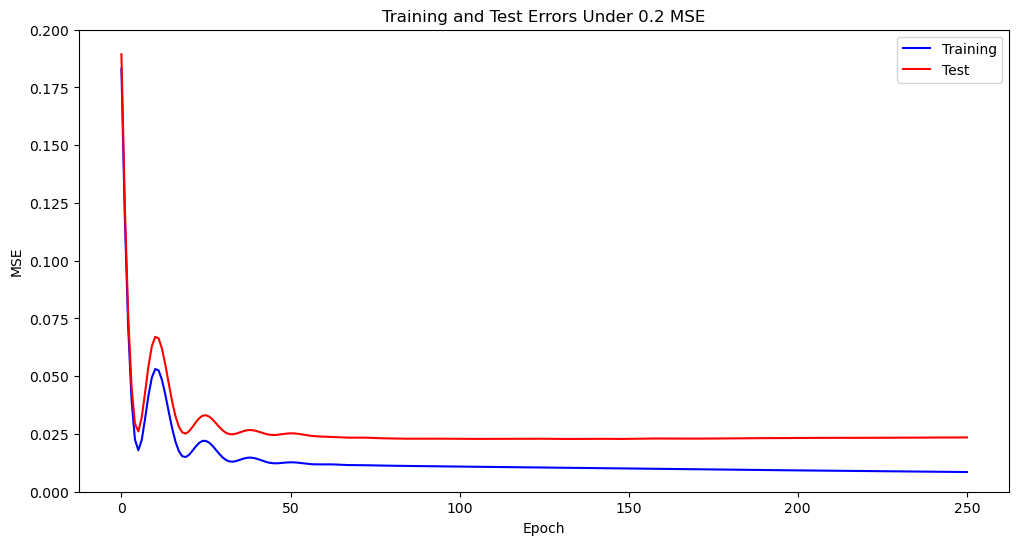

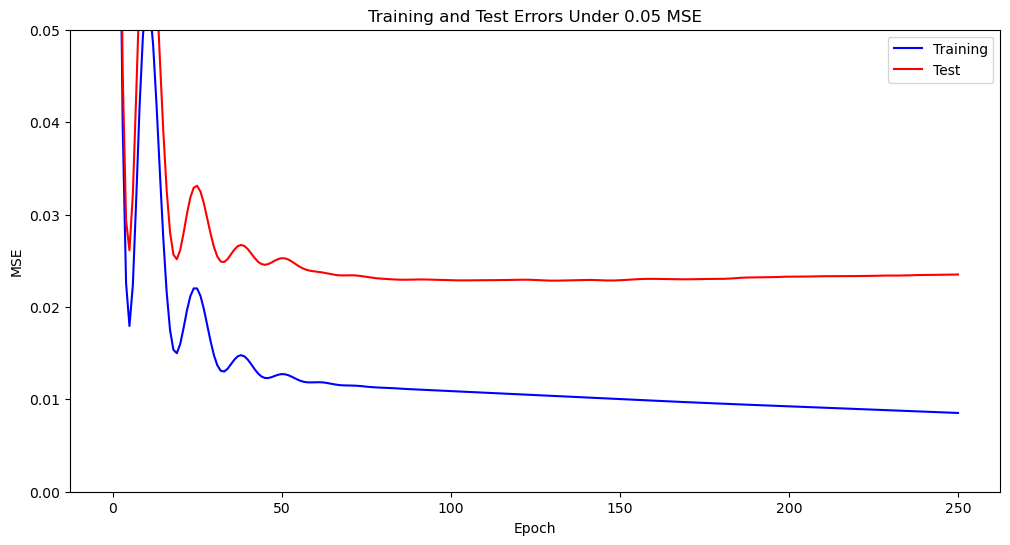

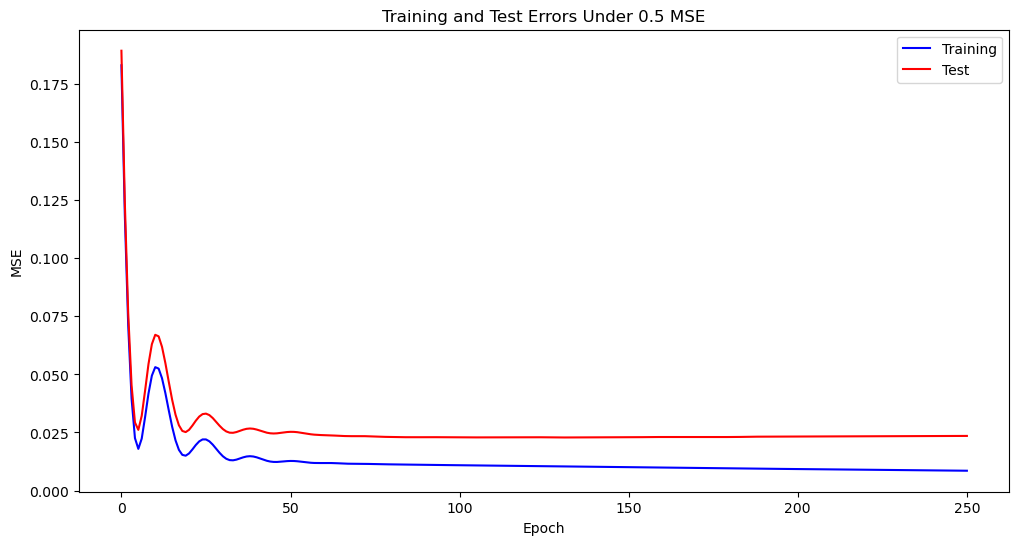

In [58]:
np.random.seed(42)
torch.manual_seed(42)

# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)

scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])

x = deposit_data[['X','Y', 'Z'] + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[mineral]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),8)
x = x[:,[0,1,2,3,4,5,6,7]]





x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Iterate through unique 'Name' values and assign each hole's data to either train or test
for name in unique_names:
    # Select data for the current hole
    hole_data = deposit_data[deposit_data['Name'] == name]
    x_hole = hole_data[['X','Y', 'Z'] + covariates].values
    y_hole = hole_data['Density_gcm3'].values

    # Assign the hole's data to either train or test
    if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
        x_test.extend(x_hole)
        y_test.extend(y_hole)
    else:
        x_train.extend(x_hole)
        y_train.extend(y_hole)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


model = nn.Sequential(
    nn.Linear(in_features=8, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(251):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()










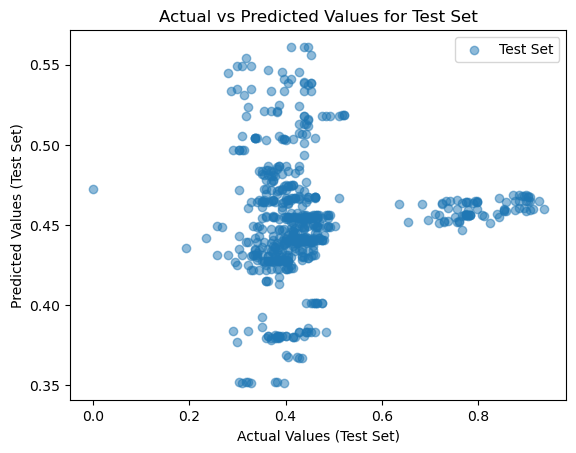

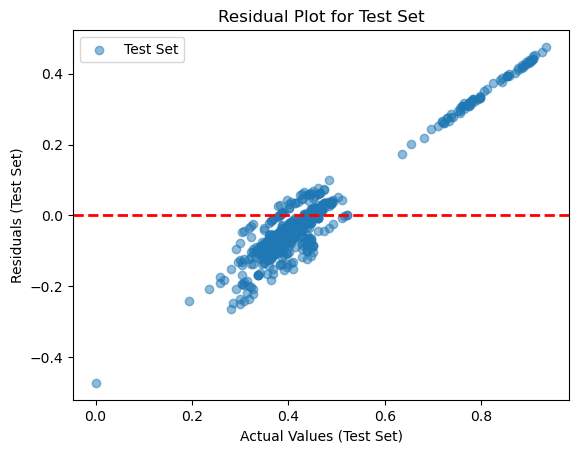

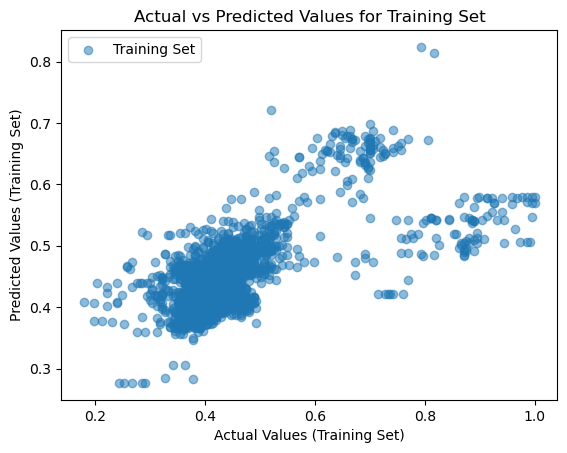

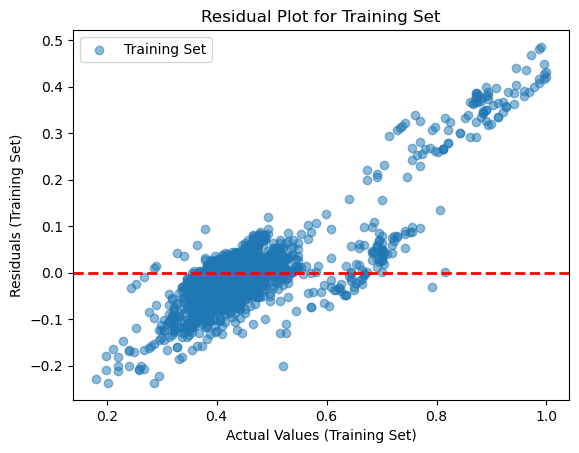

Metrics for Test set:
  MSE: 0.0216
  RMSE: 0.1469
  MAE: 0.0971
  R^2: -0.0232

Metrics for Training set:
  MSE: 0.0085
  RMSE: 0.0921
  MAE: 0.0554
  R^2: 0.4000



In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")


C:\Users\23478671\AppData\Local\Temp\ipykernel_3556\2766523882.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_3556\2766523882.py:33: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_3556\2766523882.py:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_3556\2766523882.py:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

- Iteration 0, MSE: 0.2221


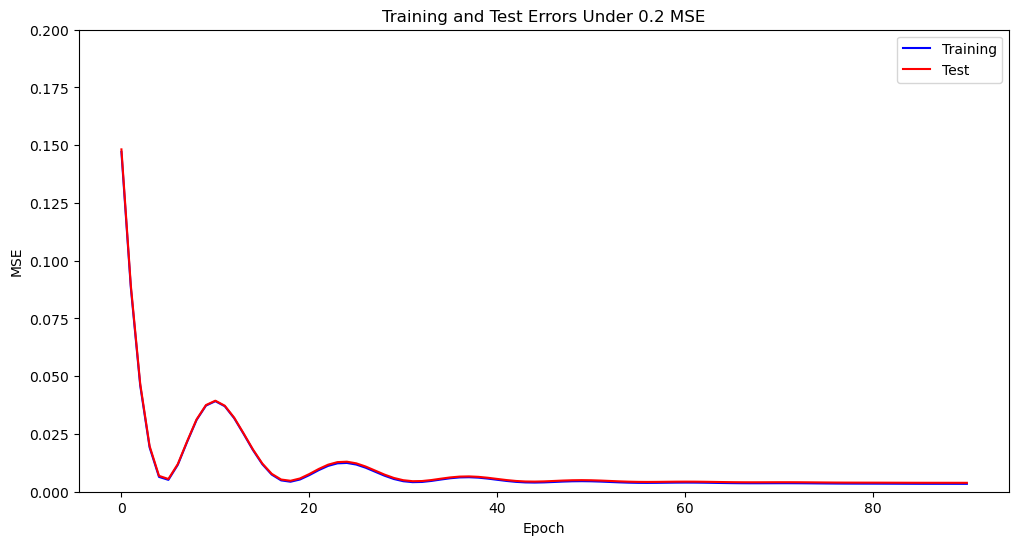

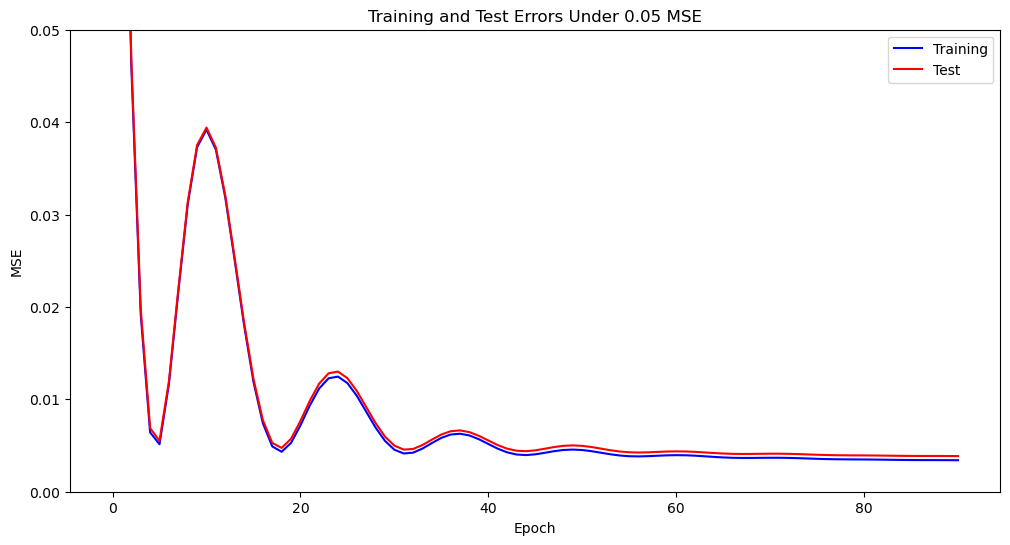

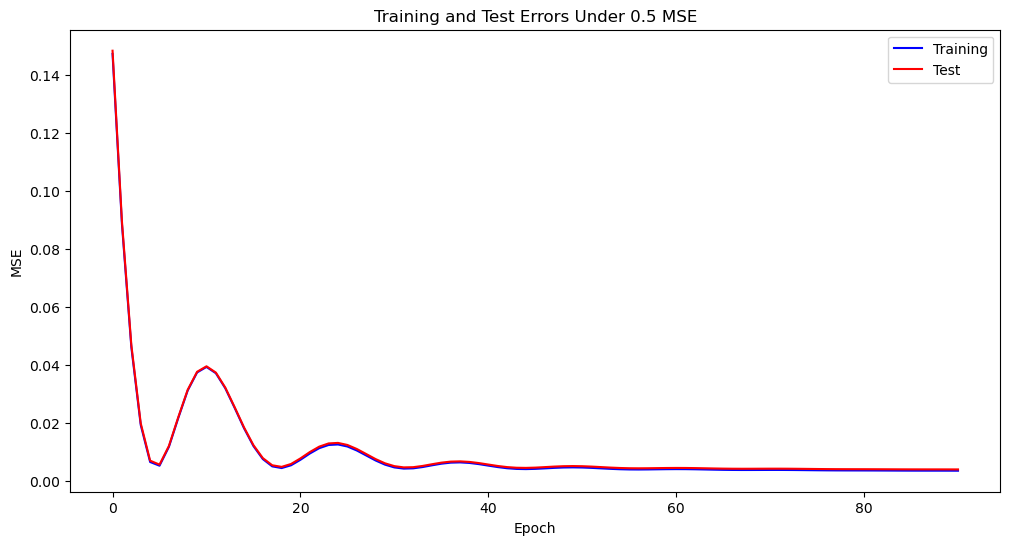

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])

x = deposit_data[covariates].values  # Use X, Y, and Z coordinates
y = deposit_data[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(deposit_data), len(covariates))

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

model = nn.Sequential(
    nn.Linear(in_features=5, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(91):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()










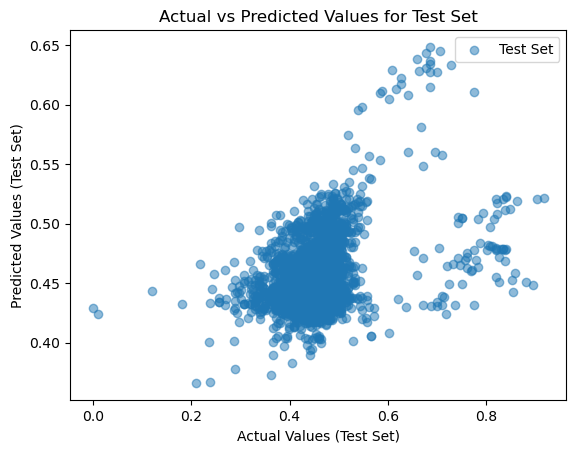

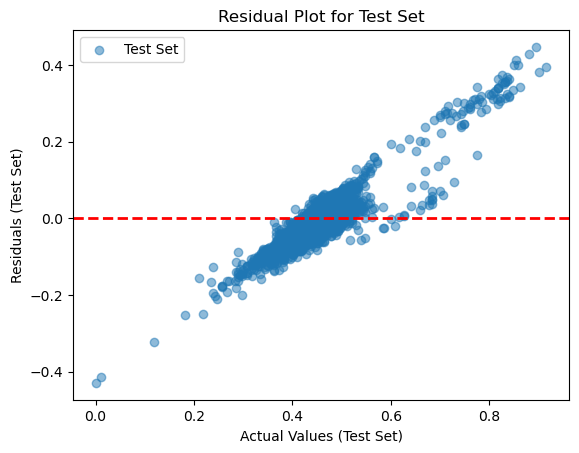

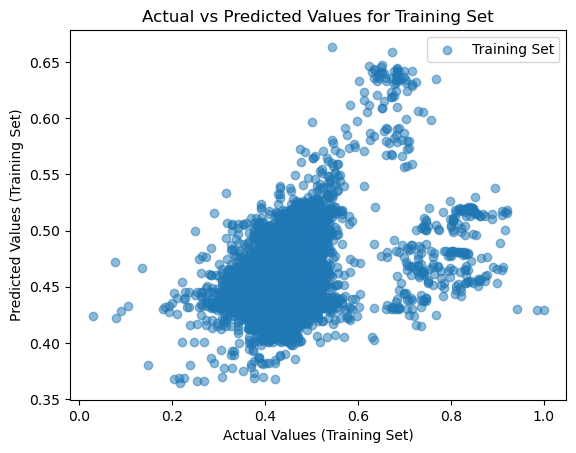

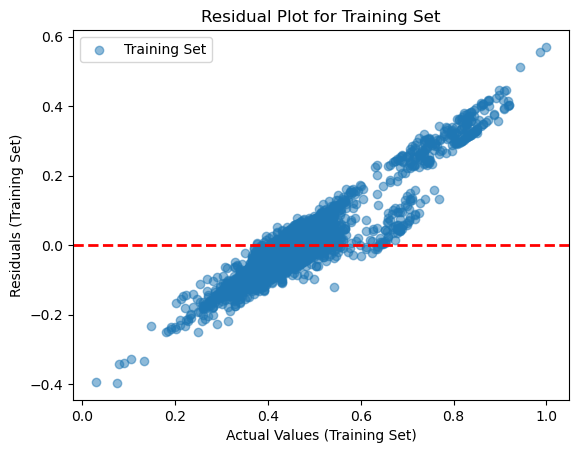

Metrics for Test set:
  MSE: 0.0039
  RMSE: 0.0621
  MAE: 0.0379
  R^2: 0.1426

Metrics for Training set:
  MSE: 0.0034
  RMSE: 0.0584
  MAE: 0.0362
  R^2: 0.1500



In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")


In [55]:
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")



In [57]:
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Extract unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[['X', 'Y', 'Z'] + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[['X', 'Y', 'Z'] + covariates].values
    y_test = test_data['Density_gcm3'].values


    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=8, out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(2400):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_rmse_list.append(np.sqrt(test_mse_list[-1]))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0072
  RMSE: 0.0849
  MAE: 0.0563
  R^2: 0.5480


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0086
  RMSE: 0.0925
  MAE: 0.0604
  R^2: 0.3468


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0046
  RMSE: 0.0675
  MAE: 0.0430
  R^2: 0.6906


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0050
  RMSE: 0.0708
  MAE: 0.0457
  R^2: 0.6289


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0084
  RMSE: 0.0914
  MAE: 0.0572
  R^2: 0.5352


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0082
  RMSE: 0.0907
  MAE: 0.0546
  R^2: 0.3530


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0103
  RMSE: 0.1014
  MAE: 0.0662
  R^2: 0.4306


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0127
  RMSE: 0.1129
  MAE: 0.0700
  R^2: 0.2926


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0076
  RMSE: 0.0874
  MAE: 0.0598
  R^2: 0.3976


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0149
  RMSE: 0.1222
  MAE: 0.0700
  R^

In [65]:
import torch
import numpy as np

# Assuming `model` is your trained neural network
model.eval()

# Choose a specific instance for interpretation (e.g., the first instance in the test set)
instance_index = 0
selected_instance = torch.tensor(x_test[instance_index], dtype=torch.float32).unsqueeze(0)  # Add a batch dimension

# Enable gradient computation
selected_instance.requires_grad_(True)

# Forward pass
output = model(selected_instance)

# Backward pass to compute gradients
model.zero_grad()
output.backward()

# Get gradients with respect to the input features
gradients = selected_instance.grad.detach().numpy()

# Calculate feature importance as the absolute mean of gradients across instances
average_importance = np.abs(gradients).mean(axis=0)

# Print or use the average_importance as needed
print("Average Feature Importance:", average_importance)


Average Feature Importance: [0.11979582 0.25387996 0.02956512 0.1269802  0.12629098 0.02837526
 0.1157214  0.11592513]


In [67]:
import torch
import numpy as np

# Assuming `model` is your trained neural network
model.eval()

# Initialize an array to accumulate gradients for each feature
total_gradients = np.zeros_like(x_test[0], dtype=float)

# Iterate over all instances to accumulate gradients
for instance_index in range(len(x_test)):
    selected_instance = torch.tensor(x_test[instance_index], dtype=torch.float32).unsqueeze(0)  # Add a batch dimension
    selected_instance.requires_grad_(True)
    
    # Forward pass
    output = model(selected_instance)

    # Backward pass to compute gradients
    model.zero_grad()
    output.backward()

    # Accumulate gradients for each feature
    total_gradients += selected_instance.grad.detach().numpy()[0]

# Calculate feature importance as the absolute mean of gradients across instances
average_importance = np.abs(total_gradients / len(x_test))

# Print or use the average_importance as needed
print("Average Feature Importance:", average_importance)


Average Feature Importance: [0.199556   0.16135701 0.07809722 0.05853513 0.19564757 0.01488939
 0.08216101 0.06971426]
